In [1]:
# helper tools
import itertools
import numpy as np
import pandas as pd
from skbio.stats.composition import (alr_inv,
                                     closure,
                                     alr, clr)
# plotting
import ternary
import colorsys
import matplotlib
import seaborn as sns
import matplotlib.colors as mc
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# define a sampling of the different quadrants of the simplex
obs = np.array(list(set(itertools.permutations([.9, 0.05, 0.05])) \
                    | set(itertools.permutations([0.6 , 0.3, 0.1])) \
                    | set(itertools.permutations([1/3 , 1/3, 1/3]))))
# make some labels for the example
ind = ['m'+str(i+1) for i in range(obs.shape[0])]
col = ['class_' + str(i+1) for i in range(obs.shape[1])]
col_diff = ['class_' + str(i+2) + '/class_1'
            for i in range(obs.shape[1] - 1)]
# make sure it is centered
diffs = alr(obs)
diffs = diffs - diffs.mean(axis=0)
diffs = pd.DataFrame(diffs,
                     ind, col_diff)
diffs = diffs.sort_values(col_diff[0])


In [11]:
alr(obs).mean(axis = 1).reshape(-1, 1)

array([[ 1.44518588],
       [-2.89037176],
       [ 1.44518588],
       [ 1.44518588],
       [-1.24245332],
       [-1.24245332],
       [-0.20273255],
       [-0.20273255],
       [ 1.44518588],
       [ 0.        ]])

First let'ssay you have three classes for a column `categorical` with the balanced classes `class-1`, `class-2`, and `class-3`. Then you pass your microbial table with ten ASVs into Songbird with the formula ”C(categorical, Treatment(’class-1’))” and get differentials. They may look something like the following:


In [3]:
np.around(diffs,3).to_csv('tutorial-results/diffs.csv')
np.around(diffs,3)

,class_2/class_1,class_3/class_1
m2,-2.890,-2.890
m6,-1.792,-0.693
m7,-1.099,0.693
m5,-0.693,-1.792
m3,0.000,2.890
m10,0.000,0.000
m8,0.693,-1.099
m9,1.099,1.792
m4,1.792,1.099
m1,2.890,0.000


First, you may want to inspect the ranking of the ASVs with respect to the classes. In this case if you desired to separate `class-1` and `class-3` you could possibly take the log-ratio of `m2` and `m3`. However in some cases you may want to see the average probability of a given ASV bieng observed within each class. To do this you could apply the inverse alr transform to the differentials. This can be done as follows


In [4]:
# get the alr-inv probs.
p_diffs = alr_inv(diffs)
# make a dataframe
p_diffs = pd.DataFrame(p_diffs,
                       diffs.index,
                       col)
np.around(p_diffs,3).to_csv('tutorial-results/inv-alr-pdiffs.csv')
np.around(p_diffs,3)

,class_1,class_2,class_3
m2,0.900,0.050,0.050
m6,0.600,0.100,0.300
m7,0.300,0.100,0.600
m5,0.600,0.300,0.100
m3,0.050,0.050,0.900
m10,0.333,0.333,0.333
m8,0.300,0.600,0.100
m9,0.100,0.300,0.600
m4,0.100,0.600,0.300
m1,0.050,0.900,0.050


Now we can inspect how each ASV falls within the simplex of the classes. We can plot this using the ternary plot package in python.



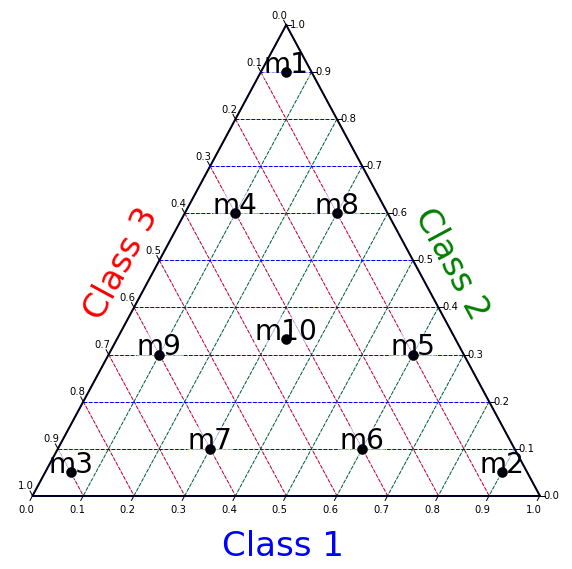

In [5]:
# Scatter Plot
scale = 1.0
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(scale*10, scale*10)
# Plot a few different styles with a legend
tax.scatter(p_diffs.values,
            marker='o',
            s=100,
            color='black')
for ind, loc in zip(p_diffs.index, p_diffs.values):
    tax.annotate(ind,
                 loc,
                 ha='center',
                 bbox=dict(boxstyle='round', fc='white',
                           alpha=.8, ec='none', pad=.01),
                 fontsize=28,
                 zorder=-1)

# add grid colors
for i in np.arange(0, 1.0, .1):
    tax.right_parallel_line(i, linewidth=1.,
                            color='red',
                            linestyle="--",
                        zorder=-1)
for i in np.arange(0, 1.0, .1):
    tax.left_parallel_line(i, linewidth=1.,
                           color='green',
                           linestyle="--",
                        zorder=-1)
for i in np.arange(0, 1.0, .1):
    tax.horizontal_line(i, linewidth=1.,
                        color='blue',
                        linestyle="--",
                        zorder=-1)
# axis labels
tax.bottom_axis_label('Class 1',
                      fontsize=34,
                      color='blue')
tax.right_axis_label('Class 2',
                     fontsize=34,
                     color='green')
tax.left_axis_label('Class 3',
                    fontsize=34,
                    color='red')
# set boundry types 
tax.boundary(linewidth=2.0)
tax.gridlines(multiple=.1,
              color="blue")
tax.ticks(axis='lbr',
          linewidth=1,
          multiple=0.1,
          tick_formats="%.1f")
tax.ax.set_facecolor('gray')
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
figure.patch.set_facecolor('None')    
tax.savefig('tutorial-results/toy-simplex.pdf',
                dpi=1000)
tax.show()


Now we can make an example of a score determined through the simplex of probability values.

$$
\begin{align}
\mathrm{seeding\,\,effectiveness} = \frac{\beta_{class-1}^{(\mathrm{alr}^{-1})} * \beta_{class-2}^{(\mathrm{alr}^{-1})} }{\frac{\beta_{class-3}^{(\mathrm{alr}^{-1})}}{1 + N_{classes}} }
\end{align}
$$

First, let's calculate that score

In [6]:
score = (p_diffs['class_1'] * p_diffs['class_2']) + (p_diffs['class_3'] / 4)
scoredf = pd.DataFrame(score, columns = ['score'])
scoredf

,score
m2,0.057500
m6,0.135000
m7,0.180000
m5,0.205000
m3,0.227500
m10,0.194444
m8,0.205000
m9,0.180000
m4,0.135000
m1,0.057500


Now we call add colors to that score using matplotlib color mapping


In [7]:
def lighten_color(color, amount=1):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# color map
colors_ = sorted(set(scoredf.score.values))
min_ = min(colors_)
max_ = max(colors_)
cmap_ = cm.RdYlBu(np.linspace(-0.1, 1, len(colors_)))
cmap_ = {c:lighten_color(cmap_[i]) for i, c in enumerate(colors_)}
scoredf['color-map'] = [matplotlib.colors.to_hex(np.absolute(cmap_[v]))
                       for v in scoredf.score.values]
scoredf


,score,color-map
m2,0.057500,#a50026
m6,0.135000,#f57547
m7,0.180000,#fed283
m5,0.205000,#6095c4
m3,0.227500,#313695
m10,0.194444,#b2ddeb
m8,0.205000,#6095c4
m9,0.180000,#f6fbd0
m4,0.135000,#f57547
m1,0.057500,#c01a27


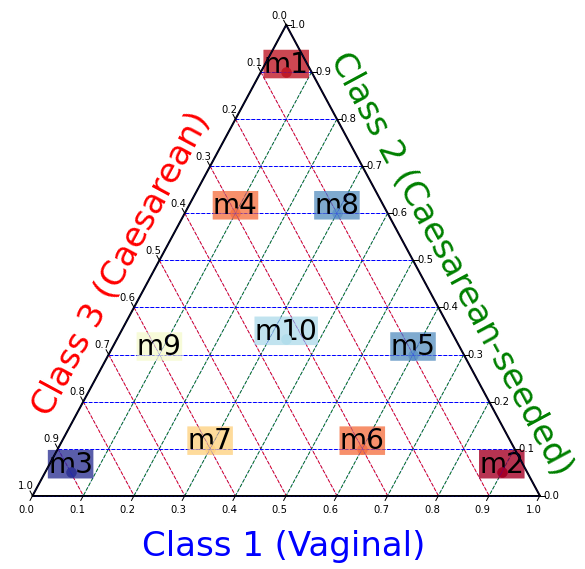

In [8]:
# Scatter Plot
scale = 1.0
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(scale*10, scale*10)
# Plot a few different styles with a legend
for k_, df_ in p_diffs.groupby(p_diffs.index):
    tax.scatter(df_.values,
                marker='o',
                s=100,
                color=scoredf.loc[k_, 'color-map'])
for ind, loc in zip(p_diffs.index, p_diffs.values):  
    tax.annotate(ind,
                 loc,
                 ha='center',
                 bbox=dict(boxstyle='round', fc=scoredf.loc[ind, 'color-map'],
                           alpha=.8, ec='none', pad=.01),
                 fontsize=28,
                 zorder=-1)

# add grid colors
for i in np.arange(0, 1.0, .1):
    tax.right_parallel_line(i, linewidth=1.,
                            color='red',
                            linestyle="--",
                        zorder=-1)
for i in np.arange(0, 1.0, .1):
    tax.left_parallel_line(i, linewidth=1.,
                           color='green',
                           linestyle="--",
                        zorder=-1)
for i in np.arange(0, 1.0, .1):
    tax.horizontal_line(i, linewidth=1.,
                        color='blue',
                        linestyle="--",
                        zorder=-1)
# axis labels
tax.bottom_axis_label('Class 1 (Vaginal)',
                     fontsize=34,
                     color='blue')
tax.right_axis_label('Class 2 (Caesarean-seeded)',
                      fontsize=34,
                      color='green')
tax.left_axis_label('Class 3 (Caesarean)',
                    fontsize=34,
                    color='red')


# set boundry types 
tax.boundary(linewidth=2.0)
tax.gridlines(multiple=.1,
              color="blue")
tax.ticks(axis='lbr',
          linewidth=1,
          multiple=0.1,
          tick_formats="%.1f")
tax.ax.set_facecolor('gray')
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
figure.patch.set_facecolor('None')    
tax.savefig('tutorial-results/toy-simplex-colored.pdf',
                dpi=1000)
tax.show()
